<a target="_blank" href="https://colab.research.google.com/github/sonder-art/automl_o24/blob/main/codigo/nlp_chatbots/lora.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Understanding LoRA: Low-Rank Adaptation of Large Language Models

## 1. Introduction to LoRA

LoRA (Low-Rank Adaptation) is a technique for efficiently fine-tuning large language models. Instead of updating all parameters during fine-tuning, LoRA adds small trainable "rank decomposition" matrices to frozen weights.

### Why LoRA?

* Traditional fine-tuning updates all parameters
* Very memory intensive
* Requires storing a full copy of the model
* LoRA reduces parameters by 10,000x while maintaining performance


### Key Concepts

The core idea of LoRA is to represent large weight updates using low-rank decomposition:

$W + \Delta W = W + BA$

where:
* $W$ is the pretrained weights (frozen)
* $\Delta W$ is our update
* $B \in \mathbb{R}^{d \times r}$ and $A \in \mathbb{R}^{r \times k}$ are low-rank matrices
* $r$ is the rank (typically 4-32)


## 2. Understanding Low-Rank Matrices

Let's first understand what low-rank matrices mean with simple examples:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Optional
import scipy.linalg as la


Matrix Rank
The rank of a matrix $A \in \mathbb{R}^{m \times n}$ is defined as:

The dimension of the column space of $A$
The dimension of the row space of $A$
The number of linearly independent columns or rows
The number of non-zero singular values in its Singular Value Decomposition (SVD)

Mathematically, if we perform SVD:
$A = U\Sigma V^T$
where:

$U \in \mathbb{R}^{m \times m}$ and $V \in \mathbb{R}^{n \times n}$ are orthogonal matrices
$\Sigma \in \mathbb{R}^{m \times n}$ is a diagonal matrix containing singular values $\sigma_1 \geq \sigma_2 \geq ... \geq \sigma_{\min(m,n)} \geq 0$

The rank is the number of non-zero singular values.

### Mathematical Foundation  
Low-rank approximation is based on the fundamental concept that many matrices can be well-approximated by matrices of lower rank. This is formalized by the Eckart-Young-Mirsky theorem, which states that the best rank-k approximation of a matrix A (in terms of both Frobenius and spectral norms) is given by:  
$A_k = \sum_{i=1}^k \sigma_i u_i v_i^T$
where:  

$\sigma_i$ are the singular values (in descending order)
$u_i$ and $v_i$ are the left and right singular vectors
k is the desired rank

### Why Low-Rank Approximations Work

**Singular Value Decay**:

In many real-world matrices, singular values decay rapidly
This means most of the matrix's "energy" is captured in the first few singular values
Mathematically: $|A - A_k|F^2 = \sum{i=k+1}^n \sigma_i^2$


**Explained Variance**:

The proportion of variance explained by k components is:
$\text{Explained Variance} = \frac{\sum_{i=1}^k \sigma_i^2}{\sum_{i=1}^n \sigma_i^2}$


**Storage Efficiency**:

Original matrix: $m \times n$ parameters
Low-rank representation: $r(m + n + 1)$ parameters
Compression ratio: $\frac{r(m + n + 1)}{mn}$

In [5]:

def create_full_rank_matrix(n: int = 10) -> np.ndarray:
    """
    Creates a random full-rank matrix using Gaussian distribution.
    
    Args:
        n (int): Size of the square matrix
        
    Returns:
        np.ndarray: A likely full-rank n×n matrix
    """
    return np.random.randn(n, n)

def create_low_rank_matrix(n: int = 10, rank: int = 2) -> np.ndarray:
    """
    Creates a low-rank matrix through matrix factorization: M = U·V
    where U is n×rank and V is rank×n, ensuring rank(M) ≤ min(rank, n)
    
    Args:
        n (int): Size of the square matrix
        rank (int): Desired rank of the matrix
        
    Returns:
        np.ndarray: A low-rank n×n matrix
    """
    if rank > n:
        raise ValueError(f"Rank ({rank}) cannot be larger than matrix dimension ({n})")
    U = np.random.randn(n, rank)
    V = np.random.randn(rank, n)
    return np.dot(U, V)

def compute_matrix_properties(matrix: np.ndarray) -> dict:
    """
    Computes various properties of a matrix including its rank, singular values,
    and condition number.
    
    Args:
        matrix (np.ndarray): Input matrix
        
    Returns:
        dict: Dictionary containing matrix properties
    """
    # Compute SVD
    U, s, Vt = np.linalg.svd(matrix)
    
    # Compute numerical rank (with tolerance for numerical stability)
    tol = np.max(matrix.shape) * np.spacing(np.max(s))
    numerical_rank = np.sum(s > tol)
    
    return {
        'rank': numerical_rank,
        'singular_values': s,
        'condition_number': s[0] / s[-1] if numerical_rank > 0 else np.inf,
        'singular_value_ratios': s[:-1] / s[1:],
    }

def plot_matrices(matrices: List[np.ndarray], 
                 titles: List[str],
                 include_analysis: bool = True) -> Tuple[plt.Figure, List[dict]]:
    """
    Visualizes matrices and their properties using heatmaps and singular value plots.
    
    Args:
        matrices (List[np.ndarray]): List of matrices to visualize
        titles (List[str]): Titles for each matrix
        include_analysis (bool): Whether to include singular value analysis
        
    Returns:
        Tuple[plt.Figure, List[dict]]: Figure and list of matrix properties
    """
    n_matrices = len(matrices)
    fig_width = 5 * n_matrices
    
    if include_analysis:
        fig, axes = plt.subplots(2, n_matrices, figsize=(fig_width, 10))
        properties_list = []
        
        for idx, (matrix, title) in enumerate(zip(matrices, titles)):
            # Matrix heatmap
            sns.heatmap(matrix, ax=axes[0, idx], cmap='coolwarm')
            axes[0, idx].set_title(f"{title}\nMatrix Values")
            
            # Compute and plot singular values
            props = compute_matrix_properties(matrix)
            properties_list.append(props)
            
            axes[1, idx].semilogy(props['singular_values'], 'o-')
            axes[1, idx].grid(True)
            axes[1, idx].set_title(f"Singular Values\nRank = {props['rank']}")
            axes[1, idx].set_xlabel('Index')
            axes[1, idx].set_ylabel('Singular Value (log scale)')
            
        plt.tight_layout()
        return fig, properties_list
    
    else:
        fig, axes = plt.subplots(1, n_matrices, figsize=(fig_width, 5))
        for ax, matrix, title in zip(axes, matrices, titles):
            sns.heatmap(matrix, ax=ax, cmap='coolwarm')
            ax.set_title(title)
        plt.tight_layout()
        return fig, []

def analyze_rank_approximation(matrix: np.ndarray, 
                             target_rank: int,
                             plot: bool = True) -> Tuple[np.ndarray, float]:
    """
    Performs low-rank approximation of a matrix and analyzes the error.
    
    Args:
        matrix (np.ndarray): Input matrix
        target_rank (int): Desired rank for approximation
        plot (bool): Whether to visualize the results
        
    Returns:
        Tuple[np.ndarray, float]: Low-rank approximation and Frobenius norm error
    """
    U, s, Vt = np.linalg.svd(matrix)
    
    # Create rank-k approximation
    s_truncated = np.zeros_like(s)
    s_truncated[:target_rank] = s[:target_rank]
    approximation = U @ np.diag(s_truncated) @ Vt
    
    # Compute error
    error = np.linalg.norm(matrix - approximation, 'fro')
    
    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        sns.heatmap(matrix, ax=axes[0], cmap='coolwarm')
        axes[0].set_title('Original Matrix')
        
        sns.heatmap(approximation, ax=axes[1], cmap='coolwarm')
        axes[1].set_title(f'Rank-{target_rank} Approximation')
        
        sns.heatmap(matrix - approximation, ax=axes[2], cmap='coolwarm')
        axes[2].set_title(f'Error (Frobenius norm: {error:.3f})')
        
        plt.tight_layout()
        
    return approximation, error

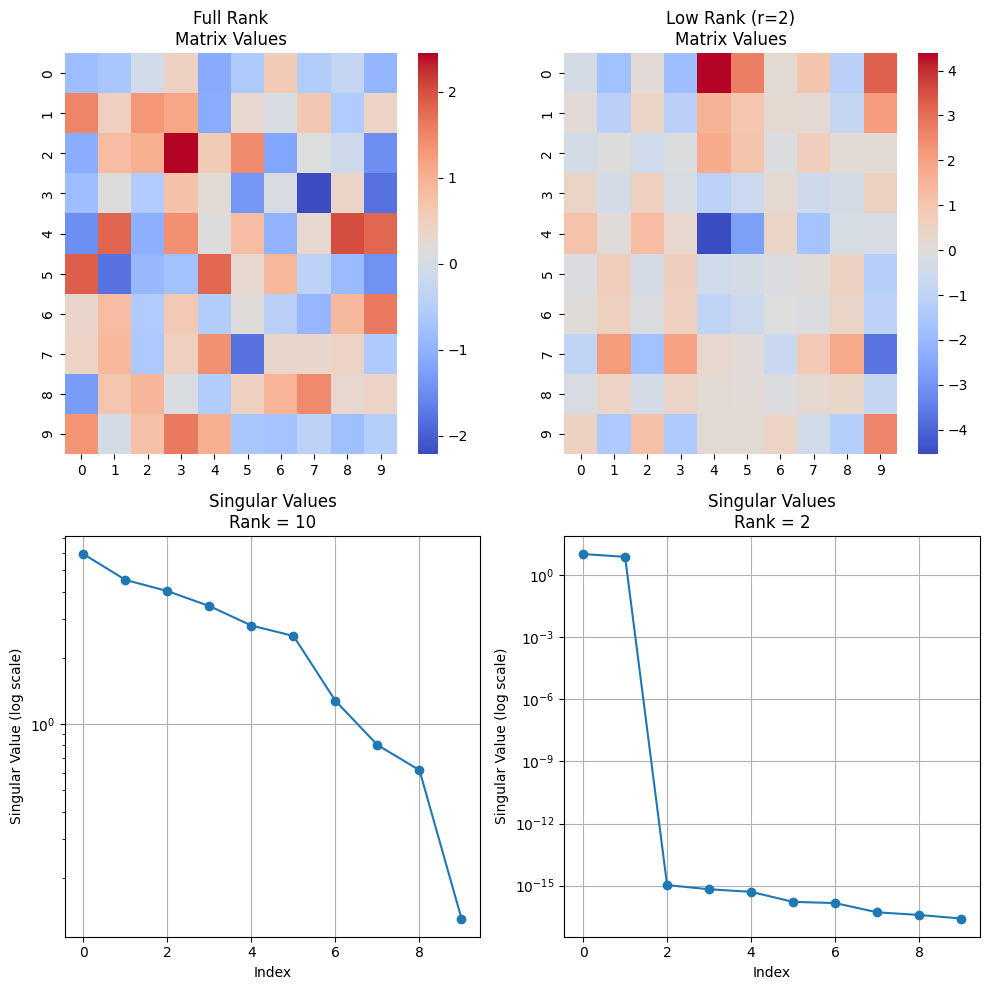

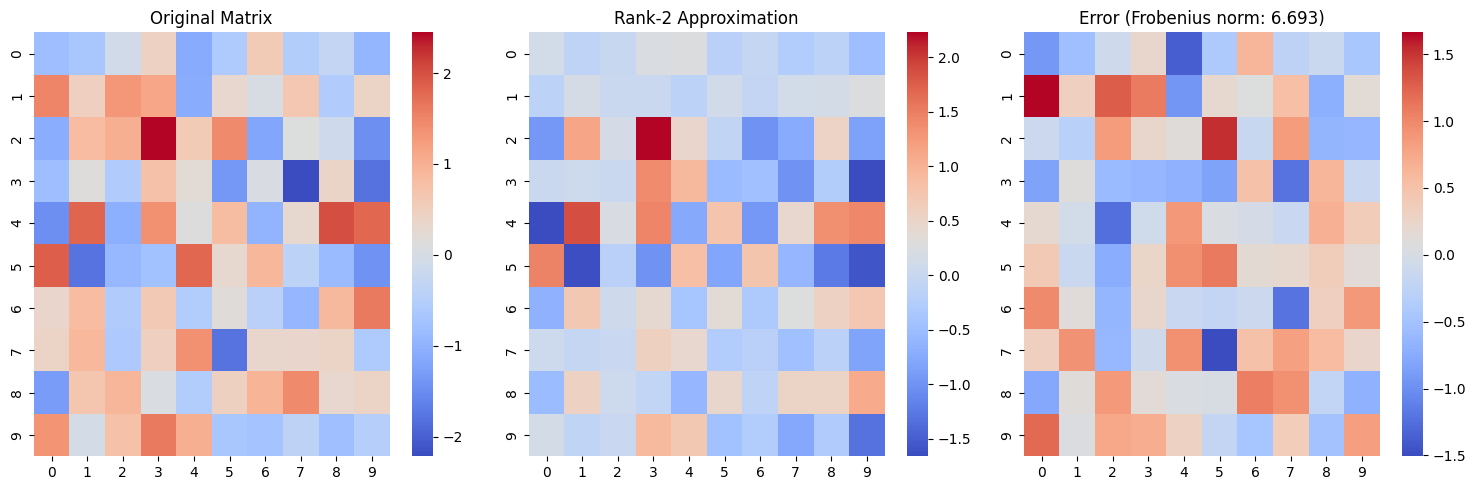

In [6]:
# Create matrices
n = 10
full_rank = create_full_rank_matrix(n)
low_rank = create_low_rank_matrix(n, rank=2)

# Visualize with analysis
fig, properties = plot_matrices([full_rank, low_rank], 
                              ['Full Rank', 'Low Rank (r=2)'],
                              include_analysis=True)

# Analyze low-rank approximation
approx, error = analyze_rank_approximation(full_rank, target_rank=2)

## 3. Implementing Simple LoRA


### 3.1 Traditional Fine-tuning Challenges

In traditional fine-tuning of large neural networks, we update all parameters $\theta \in \mathbb{R}^d$ to minimize a task-specific loss $\mathcal{L}$:

$W_{new} = W_{pretrained} + \Delta W$

For large language models, this presents several challenges:
* Space complexity: $O(d)$ for parameters
* Memory requirements: Need full copy of model
* Storage: Each fine-tuned model is size of original


### 3.2 Core Concept: Low-Rank Decomposition

Instead of learning a full update matrix $\Delta W \in \mathbb{R}^{d \times k}$, LoRA decomposes it into:

$\Delta W = BA$ where:
* $B \in \mathbb{R}^{d \times r}$
* $A \in \mathbb{R}^{r \times k}$
* $r$ is the low rank (typically $r \ll \min(d,k)$)


### 3.3 The Complete LoRA Update

The full forward pass becomes:

$h = W_0x + \Delta Wx = W_0x + (\frac{\alpha}{r})BAx$


where:
* $W_0$ is the frozen pretrained weights
* $x$ is the input
* $h$ is the output
* $\alpha$ is a scaling factor (often combined with $B$)


### 3.4 Parameter Reduction Analysis

Original update parameters: $d \times k$
LoRA parameters: $r(d + k)$

Reduction ratio: $\frac{d \times k}{r(d + k)}$

Example for a 768×768 matrix with rank 8:
* Original: 589,824 parameters
* LoRA: 12,288 parameters
* Reduction: 98% fewer parameters


### 3.5 Why Low-Rank Updates Make Sense

#### 3.5.1 Theoretical Justification


The effectiveness of LoRA is based on several theoretical insights:

1. **Intrinsic Dimensionality**: Neural networks often lie on a low-dimensional manifold
   * Updates during fine-tuning also tend to be low-rank
   * Empirically shown through SVD analysis of weight updates

2. **Information Bottleneck Theory**: 
   * Information flow through networks is naturally constrained
   * Low-rank updates preserve essential task-specific information

3. **Optimization Landscape**:
   * Low-rank updates provide smoother optimization surface
   * Reduces probability of getting stuck in poor local minima

#### 3.5.2 Mathematical Proof of Parameter Efficiency



For a weight matrix $W \in \mathbb{R}^{d \times k}$, let's analyze the SVD:

$W = U\Sigma V^T = \sum_{i=1}^{\min(d,k)} \sigma_i u_i v_i^T$

Where:
* $\sigma_i$ are singular values
* $u_i, v_i$ are left/right singular vectors

The LoRA approximation effectively captures the top-r singular values:

$\Delta W_{LoRA} \approx \sum_{i=1}^{r} \sigma_i u_i v_i^T$


### 3.5.3 Error Bounds




The Eckart-Young-Mirsky theorem gives us error bounds:

$\|\Delta W - \Delta W_{LoRA}\|_F^2 \leq \sum_{i=r+1}^{\min(d,k)} \sigma_i^2$


### 3.6 Training Dynamics


During backpropagation:

$\frac{\partial \mathcal{L}}{\partial B} = \frac{\partial \mathcal{L}}{\partial h} \cdot x^T \cdot A^T$

$\frac{\partial \mathcal{L}}{\partial A} = B^T \cdot \frac{\partial \mathcal{L}}{\partial h} \cdot x^T$


### 3.7 Initialization Strategy




LoRA uses specific initialization:
* $B$ initialized using Kaiming/Xavier initialization
* $A$ initialized to zero

This ensures:
1. At start: $\Delta W = BA = 0$
2. No initial interference with pretrained weights
3. Gradual adaptation during training


### 3.8 Scaling Factor $\alpha$


The scaling factor $\alpha$ is introduced:

$h = W_0x + \frac{\alpha}{r}BAx$


Where:
* $\alpha$ is typically set to $r$ (rank)
* Division by $r$ helps maintain variance similar to pretrained model


### 3.9 Adaptive Rank Selection


Rank can be dynamically chosen based on:

$r_i = \min(r_{max}, \lceil\beta \cdot \frac{\sigma_i}{\sigma_1}\rceil)$

where:
* $\sigma_i$ are singular values of gradient updates
* $\beta$ is a hyperparameter
* $r_{max}$ is maximum allowed rank


### 4 Merged Inference



During inference, LoRA updates can be merged:

$W_{merged} = W_0 + BA$

Benefits:
* No inference overhead
* Same speed as original model
* One-time merge cost


### PRegunta

Los parametros `W` son actualizados durante el entrenamiento o solo `AB`?


Explained Variance:
-----------------------
Given a matrix M with singular value decomposition M = UΣVᵀ:

1. Singular values (σᵢ) represent the scaling factors in each dimension  

2. Total variance = Σσᵢ² (sum of squared singular values)  

3. Explained variance of k components = (Σᵢ₌₁ᵏ σᵢ²)/(Σᵢ₌₁ⁿ σᵢ²)  

4. Cumulative explained variance at k = Σᵢ₌₁ᵏ σᵢ²/total_variance

This represents how much of the matrix's variation is captured by the first k components.

#### Pregunta  
Que es la varianza explicada? Varianza de que? Cual es el significado de `varianza` en este contexto?

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict

class LoRALab:
    """
    Educational Laboratory for understanding LoRA (Low-Rank Adaptation).
    This class provides tools to experiment with and visualize how LoRA works.
    """
    
    def __init__(self, input_dim: int, output_dim: int, rank: int, alpha: float = None):
        """
        Initialize LoRA laboratory with specific dimensions.
        
        Args:
            input_dim: Dimension of input features
            output_dim: Dimension of output features
            rank: LoRA rank (must be <= min(input_dim, output_dim))
            alpha: Scaling factor for LoRA update (default: rank)
        """
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.rank = min(rank, min(input_dim, output_dim))
        self.alpha = alpha if alpha is not None else rank
        
        # Initialize matrices
        self.W = torch.randn(output_dim, input_dim)  # Original weight matrix
        self.A = torch.zeros(rank, input_dim)        # LoRA adaptation matrix A
        self.B = torch.zeros(output_dim, rank)       # LoRA adaptation matrix B
        
        # Initialize LoRA matrices with specific methods
        self._init_lora_weights()
    
    def _init_lora_weights(self):
        """Initialize LoRA weights using Kaiming initialization"""
        torch.nn.init.kaiming_uniform_(self.A)
        torch.nn.init.kaiming_uniform_(self.B)
    
    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Compute both regular and LoRA forward passes for comparison.
        
        Args:
            x: Input tensor of shape (input_dim,)
            
        Returns:
            Dictionary containing intermediate values and final outputs
        """
        # Ensure x is the right shape
        x = x.reshape(-1, 1)
        
        # Regular path
        regular_out = self.W @ x
        
        # LoRA path with intermediate steps
        lora_first = self.A @ x                    # First LoRA transformation
        lora_second = self.B @ lora_first          # Second LoRA transformation
        lora_scaled = (self.alpha/self.rank) * lora_second  # Scaled LoRA output
        
        # Combined output
        final_out = regular_out + lora_scaled
        
        return {
            'input': x,
            'regular': regular_out,
            'lora_first': lora_first,
            'lora_second': lora_second,
            'lora_scaled': lora_scaled,
            'final': final_out
        }

    def analyze_ranks(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Analyze the rank properties of the original and LoRA matrices.
        
        Returns:
            Tuple of singular values for original and LoRA matrices
        """
        # Compute SVD for original matrix
        U1, S1, V1 = torch.linalg.svd(self.W)
        
        # Compute SVD for LoRA update matrix
        lora_update = (self.alpha/self.rank) * (self.B @ self.A)
        U2, S2, V2 = torch.linalg.svd(lora_update)
        
        return S1, S2

    def plot_rank_analysis(self):
        """Plot rank analysis with detailed explanations"""
        S1, S2 = self.analyze_ranks()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Singular Values
        ax1.plot(range(len(S1)), S1.numpy(), 'b-o', label='Original Matrix')
        ax1.plot(range(len(S2)), S2.numpy(), 'r--o', label='LoRA Update')
        ax1.set_title('Singular Value Spectrum')
        ax1.set_xlabel('i-th Singular Value (Ordered by Magnitude)')
        ax1.set_ylabel('Magnitude of Singular Value (σᵢ)')
        ax1.legend()
        ax1.grid(True)
        
        # Plot 2: Explained Variance
        var1 = np.cumsum(S1.numpy()) / np.sum(S1.numpy()) * 100
        var2 = np.cumsum(S2.numpy()) / np.sum(S2.numpy()) * 100
        
        ax2.plot(range(len(var1)), var1, 'b-o', label='Original Matrix')
        ax2.plot(range(len(var2)), var2, 'r--o', label='LoRA Update')
        ax2.set_title('Cumulative Explained Variance')
        ax2.set_xlabel('Number of Singular Values Used')
        ax2.set_ylabel('Cumulative Explained Variance (%)')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Print analysis
        print("\nRank Analysis:")
        print(f"Original matrix rank: {torch.linalg.matrix_rank(self.W).item()}")
        lora_update = (self.alpha/self.rank) * (self.B @ self.A)
        print(f"LoRA update rank: {torch.linalg.matrix_rank(lora_update).item()}")
        print(f"\nExplained Variance with first singular value:")
        print(f"Original matrix: {var1[0]:.2f}%")
        print(f"LoRA update: {var2[0]:.2f}%")

def experiment_with_ranks():
    """
    Experiment with different LoRA ranks and analyze their effects.
    """
    input_dim = 10
    output_dim = 10
    ranks = [1, 2, 4, 8]
    
    fig, axes = plt.subplots(len(ranks), 1, figsize=(12, 4*len(ranks)))
    
    for idx, rank in enumerate(ranks):
        lab = LoRALab(input_dim, output_dim, rank)
        S1, S2 = lab.analyze_ranks()
        
        axes[idx].plot(range(len(S1)), S1.numpy(), 'b-o', label='Original')
        axes[idx].plot(range(len(S2)), S2.numpy(), 'r--o', label='LoRA')
        axes[idx].set_title(f'Rank {rank}: Singular Value Comparison')
        axes[idx].set_xlabel('i-th Singular Value')
        axes[idx].set_ylabel('Magnitude')
        axes[idx].legend()
        axes[idx].grid(True)
    
    plt.tight_layout()
    plt.show()

def experiment_with_scaling():
    """
    Experiment with different scaling factors (alpha) in LoRA.
    """
    input_dim = 10
    output_dim = 10
    rank = 4
    alphas = [0.1, 1.0, 4.0, 8.0]
    
    fig, axes = plt.subplots(len(alphas), 1, figsize=(12, 4*len(alphas)))
    
    for idx, alpha in enumerate(alphas):
        lab = LoRALab(input_dim, output_dim, rank, alpha)
        
        # Create sample input
        x = torch.randn(input_dim)
        outputs = lab.forward(x)
        
        # Plot contributions
        axes[idx].bar(['Original', 'LoRA', 'Combined'], 
                     [outputs['regular'].norm().item(), 
                      outputs['lora_scaled'].norm().item(),
                      outputs['final'].norm().item()])
        axes[idx].set_title(f'Alpha = {alpha}: Contribution Magnitudes')
        axes[idx].grid(True)
    
    plt.tight_layout()
    plt.show()

# Example usage and experiments
def run_educational_experiments():
    print("Experiment 1: Basic LoRA Analysis")
    lab = LoRALab(input_dim=10, output_dim=8, rank=3)
    lab.plot_rank_analysis()
    
    print("\nExperiment 2: Effect of Different Ranks")
    experiment_with_ranks()
    
    print("\nExperiment 3: Effect of Scaling Factor")
    experiment_with_scaling()



Starting LoRA Educational Laboratory...

Example 1: Basic usage


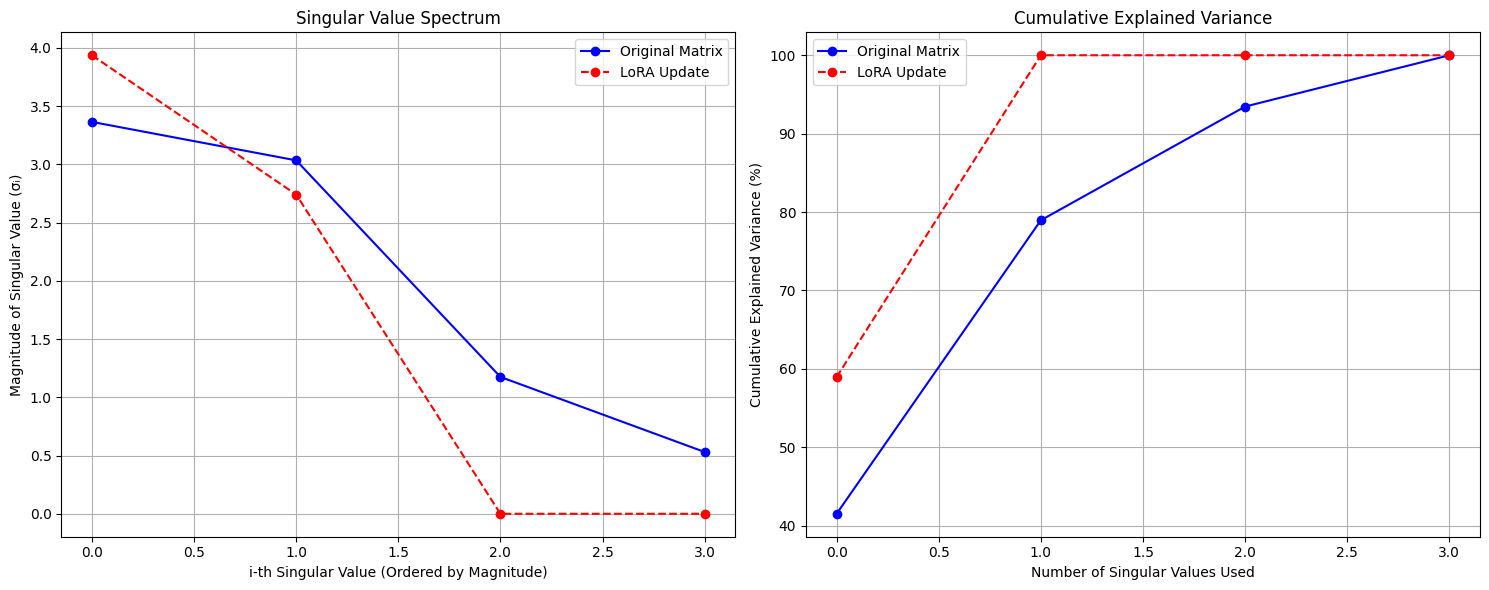


Rank Analysis:
Original matrix rank: 4
LoRA update rank: 2

Explained Variance with first singular value:
Original matrix: 41.52%
LoRA update: 58.96%

Example 2: Run all educational experiments
Experiment 1: Basic LoRA Analysis


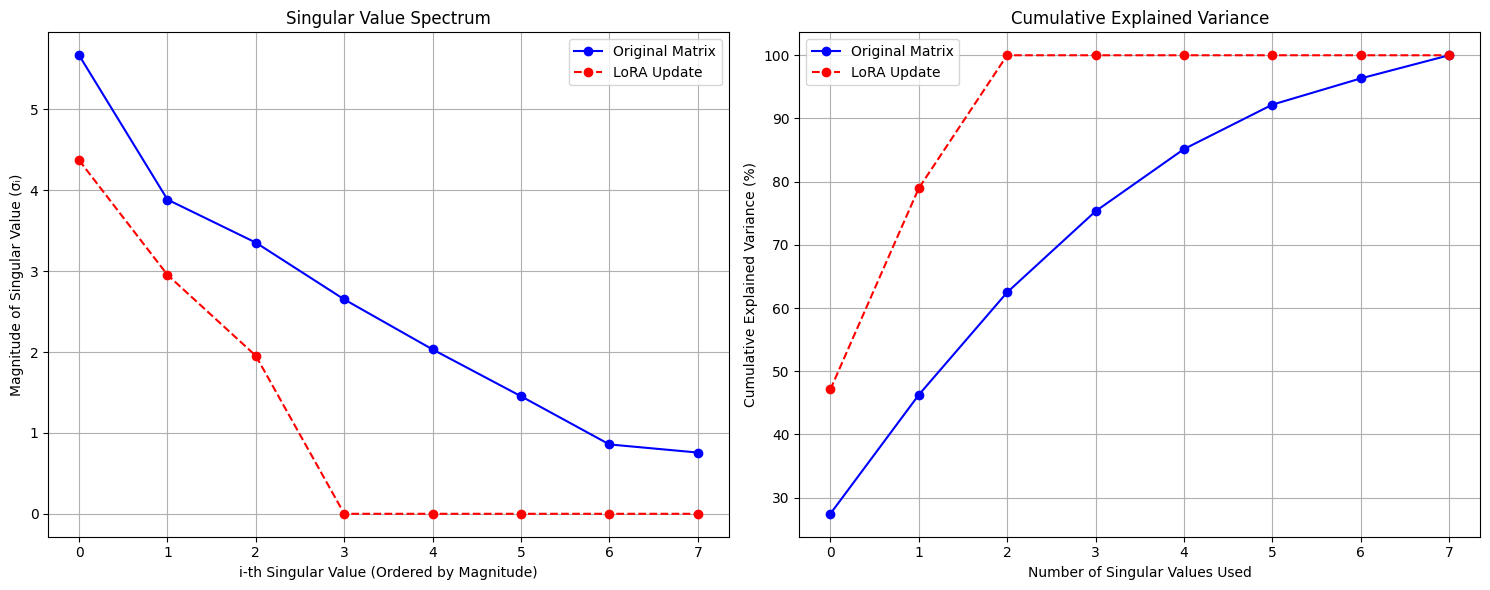


Rank Analysis:
Original matrix rank: 8
LoRA update rank: 3

Explained Variance with first singular value:
Original matrix: 27.44%
LoRA update: 47.11%

Experiment 2: Effect of Different Ranks


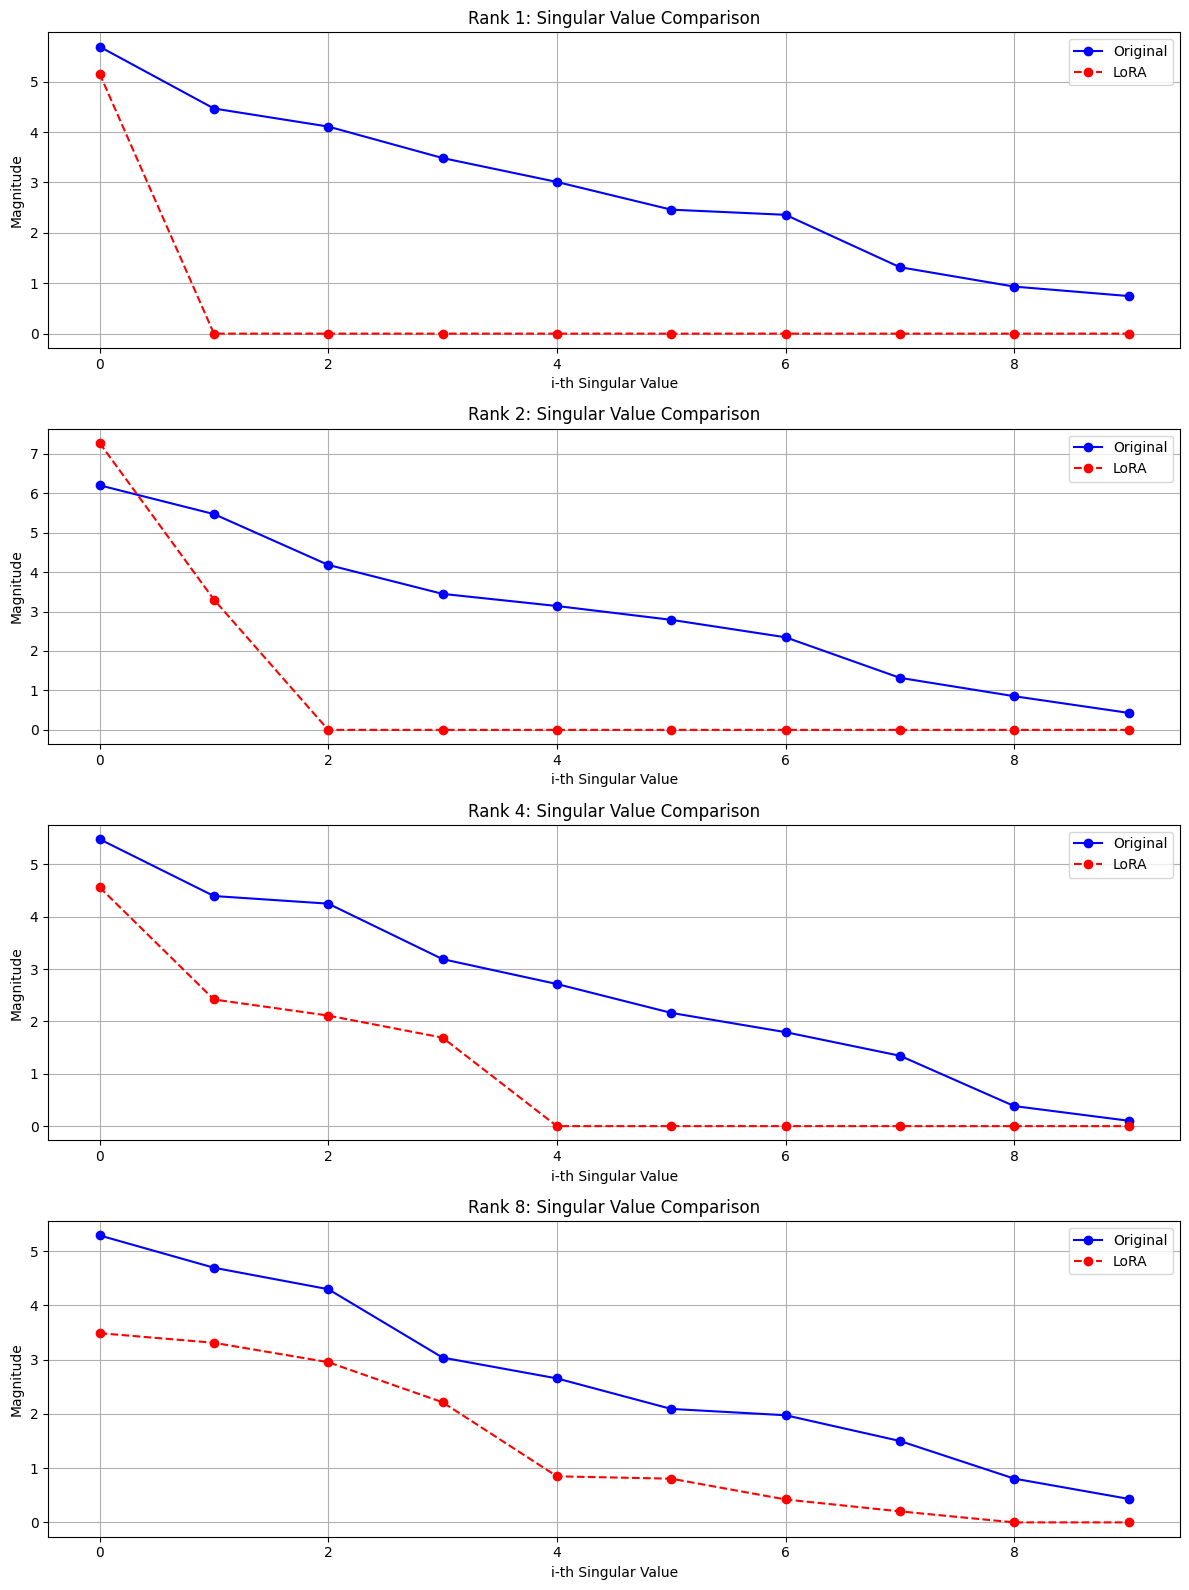


Experiment 3: Effect of Scaling Factor


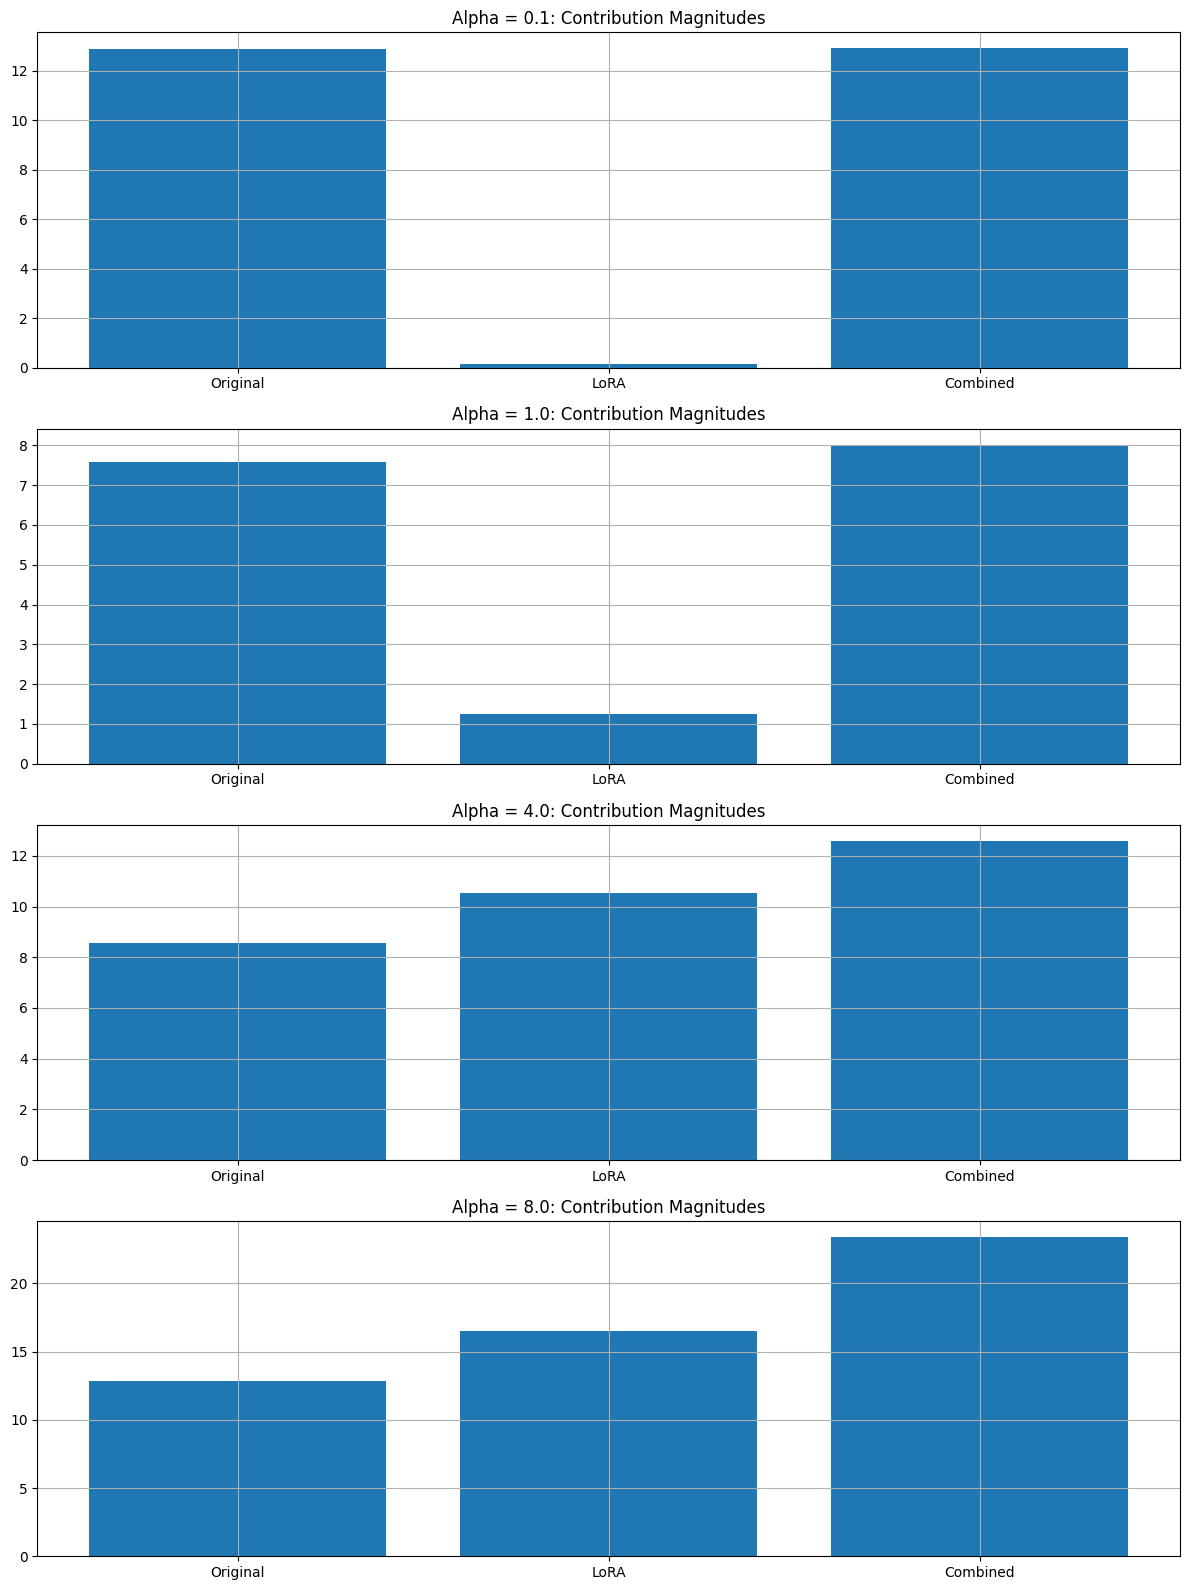

In [16]:
print("Starting LoRA Educational Laboratory...")
print("\nExample 1: Basic usage")
lab = LoRALab(input_dim=6, output_dim=4, rank=2)
lab.plot_rank_analysis()

print("\nExample 2: Run all educational experiments")
run_educational_experiments()

## Applied LoRA

In [10]:
import torch
import torch.nn as nn
import math

In [21]:
class SimpleLoRA(nn.Module):
    """
    A simple implementation of LoRA (Low-Rank Adaptation).
    
    LoRA represents weight updates ΔW as a product of two low-rank matrices:
    ΔW = BA where B ∈ ℝ^(d×r) and A ∈ ℝ^(r×k)
    """
    def __init__(self, in_features, out_features, rank, alpha=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.rank = rank
        self.alpha = alpha
        
        # Main weight matrix (pretrained weights)
        self.W = nn.Linear(in_features, out_features)
        
        # LoRA matrices
        self.lora_A = nn.Parameter(torch.randn(rank, in_features) / np.sqrt(rank))
        self.lora_B = nn.Parameter(torch.randn(out_features, rank) / np.sqrt(rank))
        
        # Freeze the main weights
        self.W.weight.requires_grad_(False)
        self.W.bias.requires_grad_(False)
    
    def forward(self, x):
        # Regular path: y = Wx
        regular_output = self.W(x)
        
        # LoRA path: y = (α/r)BAx
        lora_output = (self.alpha / self.rank) * (x @ self.lora_A.T @ self.lora_B.T)
        
        return regular_output + lora_output

In [22]:
model = SimpleLoRA(10, 5, rank=2)
x = torch.randn(3, 10)
output = model(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([3, 10])
Output shape: torch.Size([3, 5])


In [23]:
def plot_matrix_decomposition(model, figsize=(15, 5)):
    """
    Visualize the weight matrices and their decomposition.
    
    Parameters:
        model: SimpleLoRA model
        figsize: Figure size for the plot
    """
    fig, axes = plt.subplots(1, 4, figsize=figsize)
    
    # Original weights
    im1 = axes[0].imshow(model.W.weight.detach().numpy(), cmap='coolwarm', aspect='auto')
    axes[0].set_title('Original Weights (W)\n' + f'Shape: {model.W.weight.shape}')
    plt.colorbar(im1, ax=axes[0])
    
    # LoRA matrix A
    im2 = axes[1].imshow(model.lora_A.detach().numpy(), cmap='coolwarm', aspect='auto')
    axes[1].set_title('LoRA Matrix A\n' + f'Shape: {model.lora_A.shape}')
    plt.colorbar(im2, ax=axes[1])
    
    # LoRA matrix B
    im3 = axes[2].imshow(model.lora_B.detach().numpy(), cmap='coolwarm', aspect='auto')
    axes[2].set_title('LoRA Matrix B\n' + f'Shape: {model.lora_B.shape}')
    plt.colorbar(im3, ax=axes[2])
    
    # Combined update
    lora_update = (model.alpha / model.rank) * (model.lora_B @ model.lora_A).detach().numpy()
    im4 = axes[3].imshow(lora_update, cmap='coolwarm', aspect='auto')
    axes[3].set_title('LoRA Update (BA)\n' + f'Shape: {lora_update.shape}')
    plt.colorbar(im4, ax=axes[3])
    
    plt.tight_layout()
    plt.show()
    
    # Print analysis
    print("\nMatrix Analysis:")
    print(f"Original weights parameters: {model.W.weight.numel():,}")
    print(f"LoRA parameters: {(model.lora_A.numel() + model.lora_B.numel()):,}")
    print(f"Parameter reduction: {(model.lora_A.numel() + model.lora_B.numel())/model.W.weight.numel():.1%}")

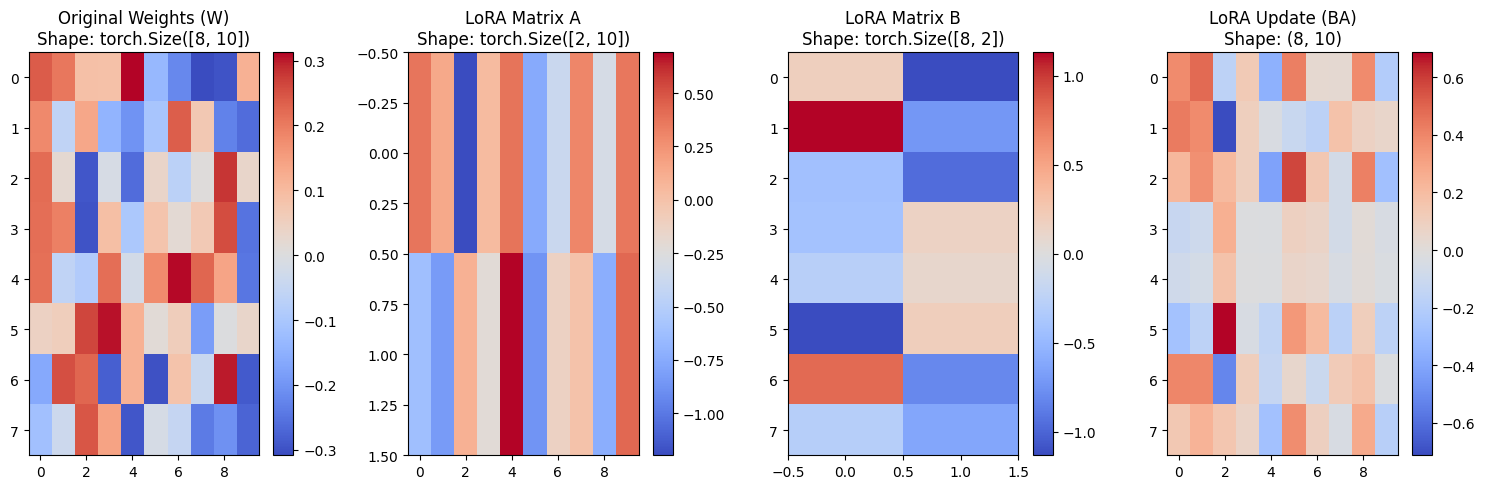


Matrix Analysis:
Original weights parameters: 80
LoRA parameters: 36
Parameter reduction: 45.0%


In [24]:
# Create a simple model
model = SimpleLoRA(in_features=10, out_features=8, rank=2)

# Visualize the matrices
plot_matrix_decomposition(model)

In [27]:
def compare_ranks(in_features=10, out_features=8, ranks=[1, 2, 4, 8]):
    """
    Compare LoRA with different ranks.
    
    Parameters:
        in_features: Input dimension
        out_features: Output dimension
        ranks: List of ranks to compare
    """
    fig, axes = plt.subplots(len(ranks), 1, figsize=(12, 4*len(ranks)))
    
    for idx, rank in enumerate(ranks):
        model = SimpleLoRA(in_features, out_features, rank)
        lora_update = (model.alpha / rank) * (model.lora_B @ model.lora_A).detach().numpy()
        
        # Compute SVD
        U, S, Vh = np.linalg.svd(lora_update)
        
        # Plot singular values
        axes[idx].bar(range(len(S)), S)
        axes[idx].set_title(f'Singular Values for Rank {rank}')
        axes[idx].set_xlabel('Index')
        axes[idx].set_ylabel('Singular Value')
        axes[idx].grid(True)
        
        # Print rank analysis
        print(f"\nRank {rank} Analysis:")
        print(f"Effective rank: {np.sum(S > 1e-5)}")
        print(f"Parameters: {(in_features + out_features) * rank:,}")
    
    plt.tight_layout()
    plt.show()




Rank 1 Analysis:
Effective rank: 1
Parameters: 18

Rank 2 Analysis:
Effective rank: 2
Parameters: 36

Rank 4 Analysis:
Effective rank: 4
Parameters: 72

Rank 8 Analysis:
Effective rank: 8
Parameters: 144


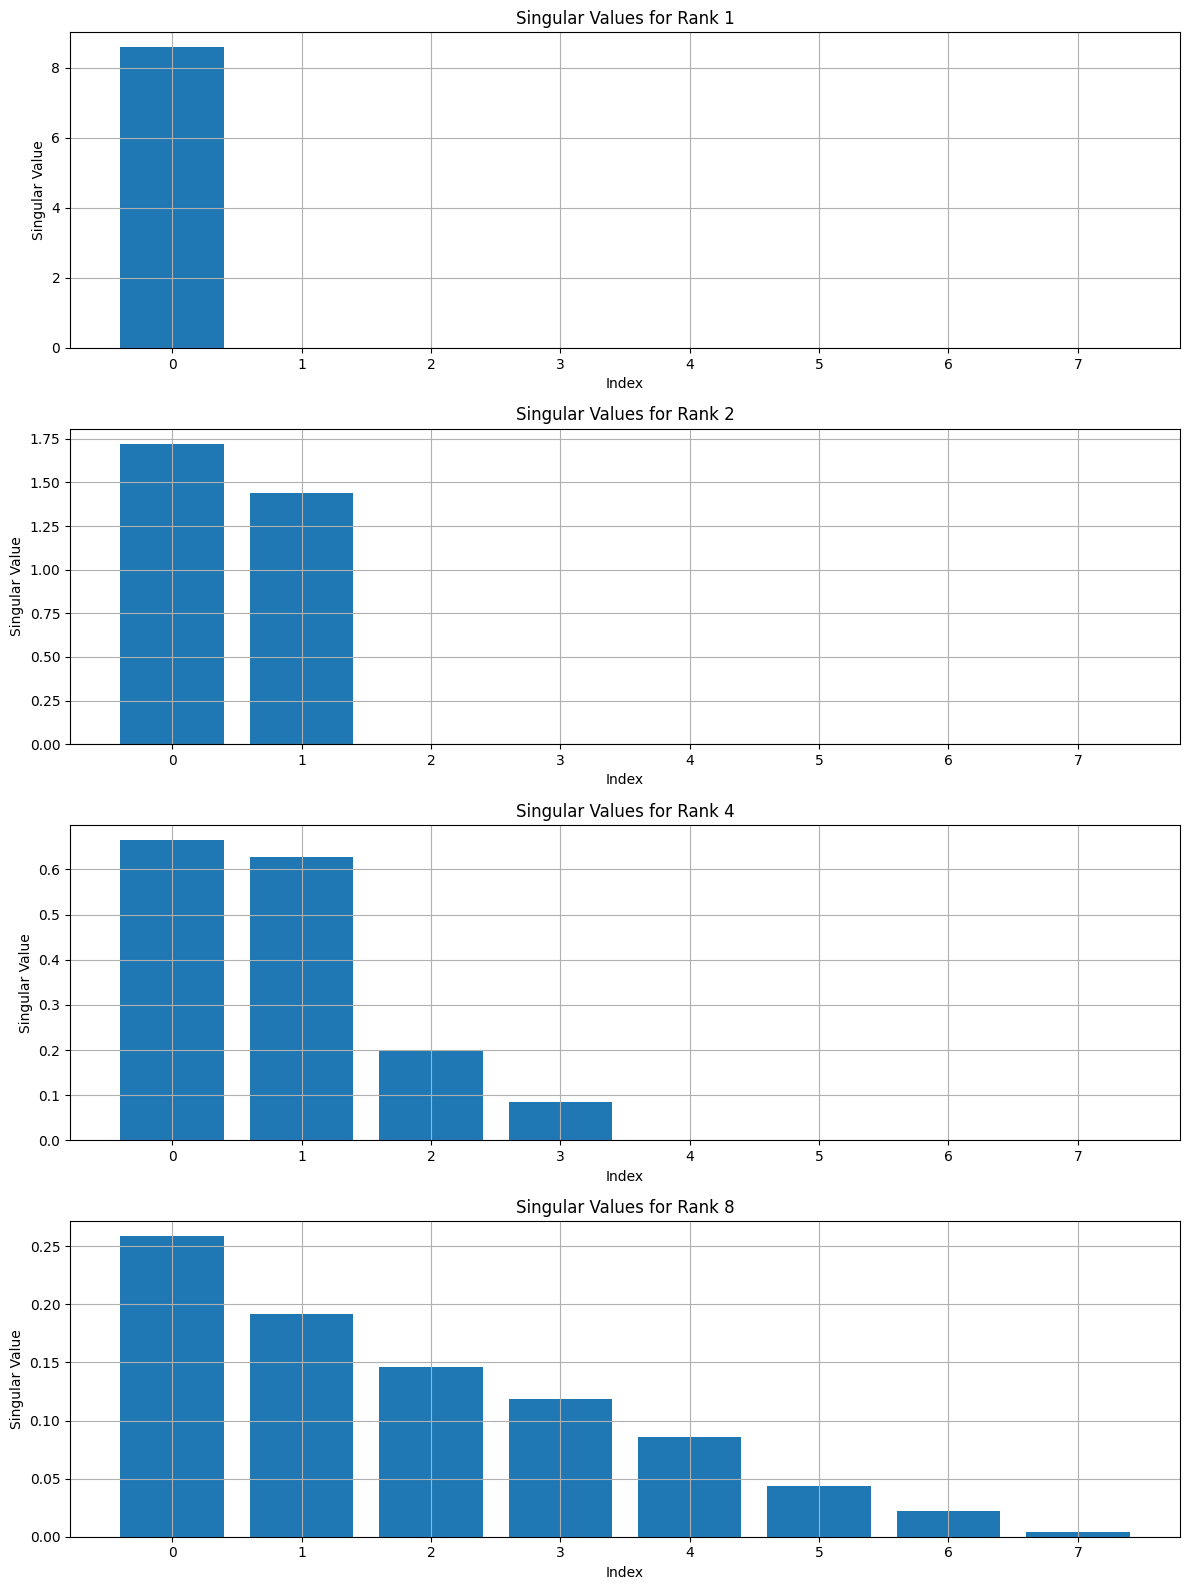

In [28]:
compare_ranks()